In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sergeyfedatsenka","key":"dd86d716c1313835b4011da2bf6e57e3"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 52.8MB/s]


In [ ]:
! unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Embedding, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

## Reading and transforming the data

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [ ]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Extracting training data and building the model

Training the model with the data as is

In [ ]:
X = train['text'].values
y = train['target'].values

X_pred =test['text'].values

In [ ]:
# splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Converting sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequence_pred = tokenizer.texts_to_sequences(X_pred)



In [ ]:
# Checking number of tokens

V = len(tokenizer.word_index)
V

19419

In [ ]:
#pad sequences to get a N x T matrix
X_train = pad_sequences(sequences_train)
print('Shape of the train tensor:', X_train.shape)

Shape of the train tensor: (6090, 32)


In [ ]:
#Getting the train_seq length (ideally we should check both lengths to prevent information loss)

T = X_train.shape[1]

X_test = pad_sequences(sequences_test, maxlen = T)
X_pred = pad_sequences(sequence_pred, maxlen = T )
print('Shape of the test tensor:', X_test.shape, 'Shape of the pred tensor:', X_pred.shape)

Shape of the test tensor: (1523, 32) Shape of the pred tensor: (3263, 32)


In [ ]:
# Creating the model
D = 20 #Choosing embdding dimensionality
M = 20 #Hidden layer dimensionality

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i, x)


In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics= ['accuracy'])

In [ ]:
# Training the model
r = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=5)

Epoch 1/5
191/191 [==============================] - 8s 27ms/step - loss: 0.6424 - accuracy: 0.6264 - val_loss: 0.5772 - val_accuracy: 0.7334
Epoch 2/5
191/191 [==============================] - 4s 23ms/step - loss: 0.3920 - accuracy: 0.8507 - val_loss: 0.4586 - val_accuracy: 0.8011
Epoch 3/5
191/191 [==============================] - 5s 29ms/step - loss: 0.2247 - accuracy: 0.9205 - val_loss: 0.4955 - val_accuracy: 0.7938
Epoch 4/5
191/191 [==============================] - 4s 23ms/step - loss: 0.1419 - accuracy: 0.9529 - val_loss: 0.5681 - val_accuracy: 0.7892
Epoch 5/5
191/191 [==============================] - 5s 25ms/step - loss: 0.0964 - accuracy: 0.9721 - val_loss: 0.5908 - val_accuracy: 0.7820


In [ ]:
pred = model.predict(X_pred)

102/102 [==============================] - 1s 5ms/step


In [ ]:
pred

array([[0.5898122 ],
       [0.93271863],
       [0.9825312 ],
       ...,
       [0.94053954],
       [0.97585744],
       [0.86596483]], dtype=float32)

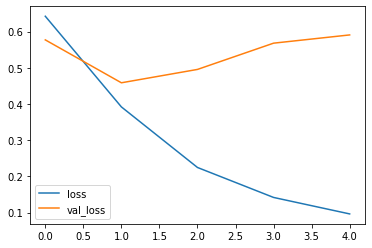

In [ ]:
#visualising the results
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

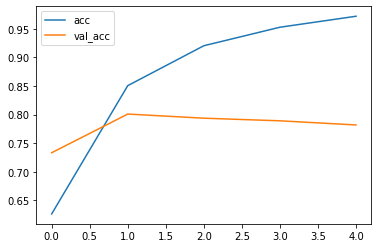

In [ ]:
plt.plot(r.history['accuracy'], label = 'acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

### Creating submission CSV

In [ ]:
df = pd.DataFrame({'id' :test['id'],'target':np.rint(pred.flatten()).astype(np.int32)})
df.head()
df.to_csv("LSTM_prediction_v0.csv",index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f LSTM_prediction_v0.csv -m "Baseline"

100% 22.2k/22.2k [00:04<00:00, 5.40kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

### Results v0

this baseline model "LSTM_prediction_v0.csv" scored 0.77658

# Possible model improvements
1. Increase the number of hidden layers: Adding more hidden layers can help the model learn more complex features and improve its accuracy.

2. Use a larger embedding dimensionality: A larger embedding dimensionality can capture more nuanced semantic relationships between words.

3. Add dropout layers: Dropout layers can prevent overfitting and improve the model's generalization ability.

4. Increase the number of training epochs: Training the model for more epochs can help it converge to a better solution.

5. Use a pre-trained word embedding: Pre-trained word embeddings like GloVe or Word2Vec can improve the quality of the model's embeddings and boost its performance.

6. Try different optimizers: Different optimizers like RMSprop or SGD may perform better for certain tasks and datasets.

7. Tune the hyperparameters: Hyperparameters such as learning rate, batch size, and regularization strength can have a significant impact on the model's performance, so it's important to experiment with different values to find the best combination.

### Data preparation

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Getting the values
X = train['text'].values
y = train['target'].values
X_pred =test['text'].values

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=6)


# Converting sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequence_pred = tokenizer.texts_to_sequences(X_pred)

# Checking/getting number of tokens
V = len(tokenizer.word_index)

#pad sequences to get a N x T matrix
X_train = pad_sequences(sequences_train)
print('Shape of the train tensor:', X_train.shape)

#Getting the train_seq length (ideally we should check both lengths to prevent information loss)
T = X_train.shape[1]
X_test = pad_sequences(sequences_test, maxlen = T)
X_pred = pad_sequences(sequence_pred, maxlen = T )
print('Shape of the test tensor:', X_test.shape, 'Shape of the pred tensor:', X_pred.shape)

Shape of the train tensor: (6471, 33)
Shape of the test tensor: (1142, 33) Shape of the pred tensor: (3263, 33)


### Updating the model 

In [ ]:
# Creating the model v1
import tensorflow as tf
from tensorflow.keras import regularizers

D = 64 #Choosing embdding dimensionality
#M = 128 #Hidden layer dimensionality

l2_reg_factor = 0.01

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg_factor), bias_regularizer=regularizers.l2(l2_reg_factor)))(x)
#x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(l2_reg_factor), bias_regularizer=regularizers.l2(l2_reg_factor)))(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.05)(x)
x = Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(l2_reg_factor), bias_regularizer=regularizers.l2(l2_reg_factor))(x)

model = Model(i, x)

#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) ,metrics= ['accuracy']) #learning_rate=0.001

# Create early stopping (once our model stops improving, stop training)
early_stopping = EarlyStopping(monitor="val_accuracy",
                              patience=3) # stops after 3 rounds of no improvements

# Training the model
r = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=5, callbacks=[early_stopping]) #callbacks=[early_stopping]


Epoch 1/5
203/203 [==============================] - 17s 66ms/step - loss: 2.5899 - accuracy: 0.6484 - val_loss: 1.7237 - val_accuracy: 0.7776
Epoch 2/5
203/203 [==============================] - 5s 26ms/step - loss: 1.3844 - accuracy: 0.8575 - val_loss: 1.3555 - val_accuracy: 0.7863
Epoch 3/5
203/203 [==============================] - 3s 13ms/step - loss: 0.9764 - accuracy: 0.9411 - val_loss: 1.3234 - val_accuracy: 0.7242
Epoch 4/5
203/203 [==============================] - 3s 16ms/step - loss: 0.7517 - accuracy: 0.9634 - val_loss: 1.2097 - val_accuracy: 0.7636
Epoch 5/5
203/203 [==============================] - 2s 11ms/step - loss: 0.5772 - accuracy: 0.9771 - val_loss: 1.1675 - val_accuracy: 0.7434


In [ ]:
pred = model.predict(X_pred)

102/102 [==============================] - 2s 5ms/step


Hyperimeter tuning does not seem  to give any result improvments

In [ ]:
df = pd.DataFrame({'id' :test['id'],'target':np.rint(pred.flatten()).astype(np.int32)})
df.head()
df.to_csv("LSTM_prediction_v2.csv",index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f LSTM_prediction_v2.csv -m "Hypertuning"

100% 22.2k/22.2k [00:00<00:00, 23.9kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

### Hyperparameters tuning did not resulted in any accuracy gain
two entries with 0.74 and 0.75

# Conclusion
The training data seem to have to much noise or is too complex for interpretation, I propose the following steps to increase the model accuracy:
1. Cleaning the data, feature engineering.
2. Trying transfer learning technics